In [26]:
# !pip install keras

In [27]:
# !pip install tensorflow 

In [10]:
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage

print('Python: {}'.format(sys.version))
print('Keras: {}'.format(keras.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('NumPy: {}'.format(numpy.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))

Python: 3.7.10 (default, Feb 26 2021, 13:06:18) [MSC v.1916 64 bit (AMD64)]
Keras: 2.4.3
OpenCV: 4.5.1
NumPy: 1.19.2
Matplotlib: 3.3.4
Scikit-Image: 0.17.2


In [11]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os


In [12]:
# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores

In [19]:
def prepare_images(path, factor):
    
    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
        print(img.shape)
        # find old and new image dimensions
#         h, w, _= img.shape
        h, w, _ = img.shape
        new_height = h // factor
        new_width = w // factor
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LANCZOS4) 
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('./images/{}'.format(file), img)
prepare_images('./pan', 2)

(512, 512, 3)
Saving 0001.png
(512, 512, 3)
Saving 0002.png
(512, 512, 3)
Saving 0003.png
(512, 512, 3)
Saving 0004.png
(512, 512, 3)
Saving 0006.png
(512, 512, 3)
Saving 0008.png
(512, 512, 3)
Saving 0013.png
(512, 512, 3)
Saving 0017.png
(512, 512, 3)
Saving 0020.png
(512, 512, 3)
Saving 0068.png
(512, 512, 3)
Saving 0069.png
(512, 512, 3)
Saving 0074.png
(512, 512, 3)
Saving 0088.png
(512, 512, 3)
Saving 0099.png
(512, 512, 3)
Saving 0116.png
(512, 512, 3)
Saving 0125.png
(512, 512, 3)
Saving 0127.png
(512, 512, 3)
Saving 0130.png
(512, 512, 3)
Saving 0137.png
(512, 512, 3)
Saving 0204.png
(512, 512, 3)
Saving 0205.png
(512, 512, 3)
Saving 0224.png
(512, 512, 3)
Saving 0264.png
(512, 512, 3)
Saving 0268.png
(512, 512, 3)
Saving 0275.png
(512, 512, 3)
Saving 0306.png
(512, 512, 3)
Saving 0312.png
(512, 512, 3)
Saving 0339.png
(512, 512, 3)
Saving 0349.png
(512, 512, 3)
Saving 0380.png
(512, 512, 3)
Saving 0440.png
(512, 512, 3)
Saving 0453.png
(512, 512, 3)
Saving 0458.png
(512, 512,

In [20]:
# define the SRCNN model
def model():
    
    # define model type
    SRCNN = Sequential()
    
    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

In [30]:
# for file in os.listdir(path="./images") : 
#     path ="./images"+"/"+file
#     print(path) 

(512, 512, 3)
(512, 512, 3)


C:\Users\Aleksandr\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Degraded Image: 
PSNR: 35.98751389288679
MSE: 49.14170565562047
SSIM: 0.9430847432724218

Reconstructed Image: 
PSNR: 36.45250436196598
MSE: 44.15208116166881
SSIM: 0.9501463843565544



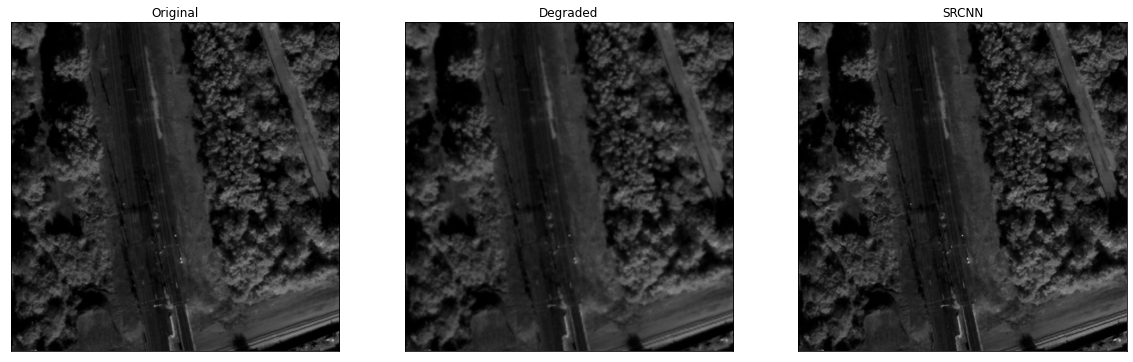

In [22]:
# define necessary image processing functions

def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img
# define main prediction function

def predict(image_path):
    
    # load the srcnn model with weights
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')
    
    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
#     ref = cv2.imread('source/{}'.format(file))
    ref = cv2.imread('pan/{}'.format(file))
    print(degraded.shape)
    print(ref.shape)
    
    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize  
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores
# ref, degraded, output, scores = predict('./images/flowers.bmp')
ref, degraded, output, scores = predict('./images/0001.png')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [25]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
for file in os.listdir('./images'):
    
    # perform super-resolution
    ref, degraded, output, scores = predict('./images/{}'.format(file))
    
    # display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
    print('Saving {}'.format(file))
    fig.savefig('./output/{}.png'.format(os.path.splitext(file)[0])) 
    plt.close()

C:\Users\Aleksandr\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Saving 0001.png
Saving 0002.png
Saving 0003.png
Saving 0004.png
Saving 0006.png
Saving 0008.png
Saving 0013.png
Saving 0017.png
Saving 0020.png
Saving 0068.png
Saving 0069.png


Saving 0074.png
Saving 0088.png
Saving 0099.png
Saving 0116.png
Saving 0125.png
Saving 0127.png
Saving 0130.png
Saving 0137.png
Saving 0204.png
Saving 0205.png
Saving 0224.png


Saving 0264.png
Saving 0268.png
Saving 0275.png
Saving 0306.png
Saving 0312.png
Saving 0339.png
Saving 0349.png
Saving 0380.png
Saving 0440.png
Saving 0453.png
Saving 0458.png


Saving 0459.png
Saving 0462.png
Saving 0465.png
Saving 0475.png
Saving 0484.png
Saving 0487.png
Saving 0488.png
Saving 0503.png
Saving 0506.png
Saving 0514.png
Saving 0517.png


Saving 0522.png
Saving 0528.png
Saving 0531.png
Saving 0536.png
Saving 0562.png
Saving 0564.png
Saving 0566.png
Saving 0570.png
Saving 0575.png
Saving 0583.png
Saving 0610.png


Saving 0611.png
Saving 0618.png
Saving 0619.png
Saving 0644.png
Saving 0649.png
Saving 0655.png
Saving 0670.png
Saving 0737.png
Saving 0911.png
Saving 1002.png
Saving 1003.png


Saving 1055.png
Saving 1094.png
Saving 1106.png
Saving 1118.png
Saving 1123.png
Saving 1124.png
Saving 1148.png
Saving 1150.png
Saving 1221.png
Saving 1317.png
Saving 1377.png


Saving 1430.png
Saving 1485.png
Saving 1521.png
Saving 1522.png
Saving 1596.png
Saving 1682.png
Saving 1773.png
Saving 1834.png
Saving 1886.png
Saving 1981.png
Saving 1982.png


Saving 1984.png
Saving 1986.png
Saving 2098.png
Saving 2165.png
Saving 2472.png
Saving 2606.png
Saving 2626.png
Saving 2773.png
Saving 2775.png
Saving 2779.png
Saving 2862.png


Saving 2864.png
Saving 2875.png
Saving 2876.png
Saving 2916.png
Saving 2920.png
Saving 3009.png
Saving 3138.png
Saving 3140.png
Saving 3319.png
Saving 3528.png
Saving 3666.png


Saving 3713.png
Saving 3728.png
Saving 3748.png
Saving 3764.png
Saving 3789.png
Saving 3832.png
Saving 3838.png
Saving 3884.png
Saving 3943.png
Saving 4067.png
Saving 4120.png


Saving 4167.png
Saving 4179.png
Saving 4181.png
Saving 4255.png
Saving 4268.png
Saving 4284.png
Saving 4314.png
Saving 4316.png
Saving 4328.png
Saving 4331.png
Saving 4347.png


Saving 4357.png
Saving 4434.png
Saving 4484.png
Saving 4610.png
Saving 4612.png
Saving 4614.png
Saving 4616.png
Saving 4785.png
Saving 4830.png
Saving 4832.png
Saving 5285.png


Saving 5288.png
Saving 5290.png
Saving 5341.png
Saving 5371.png
Saving 5373.png
Saving 5660.png
Saving 5674.png
Saving 5697.png
Saving 5717.png
Saving 5765.png
Saving 5809.png


Saving 5900.png
Saving 6023.png
Saving 6066.png
Saving 6069.png
Saving 6210.png
Saving 6211.png
Saving 6240.png
Saving 6253.png
Saving 6288.png
Saving 6394.png
Saving 6407.png


Saving 6419.png
Saving 6424.png
Saving 6776.png
Saving 6808.png
Saving 7256.png
Saving 7261.png
Saving 7304.png
Saving 7438.png
Saving 7630.png
Saving 7639.png
Saving 7785.png


Saving 7859.png
Saving 8002.png
Saving 8022.png
Saving 8072.png
Saving 8086.png
Saving 8088.png
Saving 8090.png
Saving 8093.png
Saving 8094.png
Saving 8095.png
Saving 8105.png


Saving 8107.png
Saving 8112.png
Saving 8121.png
Saving 8124.png
Saving 8126.png
Saving 8133.png
Saving 8135.png
Saving 8138.png
Saving 8156.png
Saving 8176.png
Saving 8223.png


Saving 8228.png
Saving 8230.png
Saving 8335.png
Saving 8336.png
Saving 8374.png
Saving 8377.png
Saving 8381.png
Saving 8386.png
Saving 8395.png
Saving 8424.png
Saving 8429.png


Saving 8446.png
Saving 8473.png
Saving 8511.png
Saving 8512.png
Saving 8537.png
Saving 8554.png
Saving 8561.png
Saving 8593.png
Saving 8626.png
Saving 8648.png
Saving 8674.png


Saving 8687.png
Saving 8688.png
Saving 8791.png
Saving 8800.png
Saving 8835.png
Saving 8842.png
Saving 8890.png
Saving 8962.png
Saving 8973.png
Saving 8978.png
Saving 9017.png


Saving 9018.png
Saving 9057.png
Saving 9127.png
Saving 9129.png
Saving 9167.png
Saving 9230.png
Saving 9232.png
Saving 9297.png
Saving 9304.png
Saving 9313.png
Saving 9328.png


Saving 9329.png
Saving 9333.png
Saving 9368.png
Saving 9379.png
Saving 9383.png
Saving 9405.png
Saving 9483.png
Saving 9504.png
Saving 9514.png
Saving 9714.png
Saving 9743.png


Saving 9770.png
Saving 9772.png
Saving 9884.png
Saving 9974.png
